# 线性回归从零开始实现

## Step1 setup

In [23]:
%matplotlib inline

In [24]:
import torch

# 超参数
TRUE_W = torch.tensor([2, -3.4])
TRUE_B = 4.2
NUM_EXAMPLES = 1000
LR = 0.03
NUM_EPOCHS = 3
BATCH_SIZE = 10

## Step2 构造数据集

In [ ]:
def synthetic_data(w, b, num_examples):
    """
    生成 "y = Xw + b + noise" 数据
    """
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = X @ w + b
    y += torch.normal(0, 0.01, y.shape)
    
    return X, y.reshape((-1, 1))

In [26]:
features, labels = synthetic_data(TRUE_W, TRUE_B, NUM_EXAMPLES)

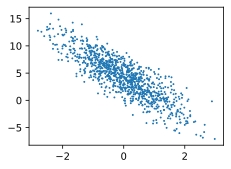

In [27]:
from utils import set_figsize
from matplotlib import pyplot as plt

# 数据可视化
set_figsize()
plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

In [28]:
import random

def data_iter(features, labels, BATCH_SIZE):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 随机读取
    
    for i in range(0, num_examples, BATCH_SIZE):
        batch_indices = torch.tensor(
            indices[i: min(i + BATCH_SIZE, num_examples)]
        )
        yield features[batch_indices], labels[batch_indices]

## Step3 定义模型

In [29]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [30]:
def linreg(X, w, b):
    """
    线性回归模型
    """
    return X @ w + b

## Step4 定义损失函数

In [31]:
def squared_loss(y_hat, y):
    """
    均方损失
    """
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## Step5 定义优化算法

In [32]:
def sgd(params, LR, BATCH_SIZE):
    """
    小批量随机梯度下降
    """
    with torch.no_grad():
        for param in params:
            param -= LR * param.grad / BATCH_SIZE
            param.grad.zero_()

## Step6 训练

In [33]:
for epoch in range(NUM_EPOCHS):
    for X, y in data_iter(features, labels, BATCH_SIZE):
        y_hat = linreg(X, w, b)
        loss = squared_loss(y_hat, y)  # 计算小批量损失
        loss.sum().backward()  # l 的形状 (bs, 1) 反向传播要求 loss 是标量
        sgd([w, b], LR, BATCH_SIZE)  # 使用参数的梯度更新参数
    
    # 使用全部的数据计算 loss, 检查 loss 变化
    with torch.no_grad():
        y_hat = linreg(features, w, b)
        loss = squared_loss(y_hat, labels).mean()
        print(f'epoch: {epoch + 1}, mean_square_loss: {float(loss):f}')

epoch: 1, mean_square_loss: 0.038999
epoch: 2, mean_square_loss: 0.000144
epoch: 3, mean_square_loss: 0.000050


In [34]:
print(f'w 的估计误差: {TRUE_W - w.reshape(TRUE_W.shape)}')
print(f'b 的估计误差: {TRUE_B - b}')

w 的估计误差: tensor([ 0.0006, -0.0005], grad_fn=<SubBackward0>)
b 的估计误差: tensor([0.0008], grad_fn=<RsubBackward1>)


# 线性回归 PyTorch 实现

## Step1 数据集

In [35]:
from torch.utils.data import DataLoader, TensorDataset

def load_array(data_arrays, batch_size, is_train=True):
    """
    构造一个 PyTorch 数据迭代器
    """
    dataset = TensorDataset(*data_arrays)
    return DataLoader(dataset, batch_size, shuffle=is_train)

In [36]:
data_iter = load_array((features, labels), BATCH_SIZE)

## Step2 定义模型

In [37]:
from torch import nn

net = nn.Sequential(
    nn.Linear(2, 1)
)

# 初始化模型参数
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

## Step3 定义损失函数

In [38]:
loss = nn.MSELoss()

## Step4 定义优化算法

In [39]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## Step5 训练

In [40]:
for epoch in range(NUM_EPOCHS):
    for X, y in data_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    
    l = loss(net(features), labels)
    print(f'epoch: {epoch + 1}, MSEloss: {l:f}')

epoch: 1, MSEloss: 0.000246
epoch: 2, MSEloss: 0.000100
epoch: 3, MSEloss: 0.000099


In [41]:
w = net[0].weight.data
b = net[0].bias.data

print('w 的估计误差：', TRUE_W - w.reshape(TRUE_W.shape))
print('b 的估计误差：', TRUE_B - b)

w 的估计误差： tensor([-3.8052e-04, -7.1049e-05])
b 的估计误差： tensor([6.8188e-05])
